Introduction

-	Find a promising pair of stocks (a nice candidate for mean-reversion bets) whose prices are nicely normally distributed. 
-	Fit them as a joint-normal distribution for some sanity check.
-	This bivariate Gaussian model says that such co-moves are very unlikely to happen since they are so close to the tails of the distribution, and you better ignore it. 
-	The stocks tend to move downward together more than going upward, and the bivariate Gaussian distribution says it should be symmetric.


Two major pitfalls of a bivariate normal distribution:
1.	Marginal random variables being normally distributed does not mean they together are jointly-normally distributed.
2.	Unrealistic assumptions: linear correlation of the data from the two legs, no tail-dependence, and upper-lower end symmetry …


But, 
-	A detail-oriented trader tries to capture the non-linear dependencies. 
-	But what if the two stocks are not normally distributed in history, to begin with? What if one stock has an upward drift and it always punches through the 3 standard deviation ceiling of your assumed marginal distribution in the testing set?
-	To answer the mystery one must understand the concept copula.


Copula's Advantages:
1.	It separates the marginal distributions from studying their “relation”, so you don’t need to worry about taking into account all the possible combinations of possible types of univariate distributions.
2.	You can tune the dependency structure to your own liking, especially the tail dependencies.
3.	You can work with multiple stocks in a cohort, instead of just a pair.
4.	Much less crowded compared to other common quant strategies like vanilla distance and cointegration..

- The key idea lies in modeling the relation between two random variables’ quantiles to avoid involving idiosyncratic marginal distributions.

An Example

Make the Q-Q (quantile-quantile) plot of two continuous random variables:
1. For two continuous random variables with fixed distributions, find their own marginal CDFs (cumulative density functions).
2. Sample from the two-random-variable pair multiple times.
3. Map the random samples into their quantile domain by their CDFs, you should get two uniformly distributed quantiles data in [0,1]×[0,1].
4. Plot the pair’s quantile-quantile data.

- First, knowing the marginal distribution does not in any way determine this Q-Q plot at all, and this Q-Q plot tells the full dependency structure between the two random variables, it tells us how they are “related”. 
- Second, we just plotted the samples from a copula according to its copula density $c(u_1,u_2)$, which is generally denoted as c. The denser the dots, the higher the copula density. It is still not the copula itself because copula is the joint cumulative density of quantiles $C(u_1,u_2)$, and is defined in the next section. 
- Much like when you try to plot a univariate distribution, you sample from its CDF by generating uniformly from $[0,1]$ to plot its PDF, we are doing the same thing but in 2 dimensions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pairs_selection as ps
import FinanceDataReader as fdr

In [2]:
df_ = pd.read_csv('C:data.csv')
df_ = df_.set_index('Date')
df_.index = pd.to_datetime(df_.index)
ret = df_.pct_change()[1:]
n = 5
min_samples = 4
filtered_spreads = ps.main.main(ret,n,min_samples)
filtered_spreads.head(3)

,현대모비스&현대차,현대차&SK텔레콤,현대차&기아차,현대차&SK,현대차&LG유플러스,한화솔루션&현대차,현대차&고려아연,현대글로비스&현대차,효성&현대차,현대차&현대차2우B,...,코스맥스&한국콜마,현대백화점&코스맥스,코스맥스&신세계인터내셔날,코스맥스&GKL,현대백화점&한국콜마,신세계인터내셔날&한국콜마,한국콜마&GKL,현대백화점&신세계인터내셔날,현대백화점&GKL,GKL&신세계인터내셔날
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.020834,0.016036,0.020864,0.030464,0.017926,-0.052218,0.002883,0.046185,0.002830,-0.012228,...,-0.007622,0.001701,-0.007066,-0.017028,0.000517,-0.010581,-0.010980,0.003242,-0.007917,0.016014
2019-01-04,0.019095,0.017978,-0.016816,0.022382,0.029722,-0.000759,0.013208,0.021652,-0.032657,-0.002165,...,0.014739,0.001284,0.010234,-0.000657,0.004483,0.024136,-0.014703,-0.003203,-0.015428,0.032079
2019-01-07,-0.011501,0.014115,0.021409,0.003032,0.001695,0.011079,0.021088,-0.023297,0.004501,0.013301,...,0.007130,-0.002999,0.023659,0.022550,-0.003320,-0.029078,0.018405,0.010982,0.009752,-0.005064


In [3]:
# choose first pairs

pair_name = filtered_spreads.columns[0]
pair_name.split('&')

['현대모비스', '현대차']

In [4]:
stock1 = df_[pair_name.split('&')[0]]
stock2 = df_[pair_name.split('&')[1]]
spread = filtered_spreads[pair_name]

In [66]:
bi_stock = pd.concat([stock1,stock2], axis=1)
bi_ret = bi_stock.pct_change().iloc[1:,:]
bi_ret = bi_ret.rename(columns={pair_name.split('&')[0]:'first',pair_name.split('&')[1]:'second'})
bi_ret

,first,second
Date,,
2019-01-03,0.037838,0.021930
2019-01-04,0.039062,0.025751
2019-01-07,-0.005013,0.008368
2019-01-08,-0.027708,-0.008299
2019-01-09,0.049223,0.029289
...,...,...
2021-02-22,0.004666,-0.002066
2021-02-23,0.006192,0.012422
2021-02-24,-0.046154,-0.038855


In [67]:
from copulas import bivariate, multivariate

In [69]:
copula1 = multivariate.GaussianMultivariate()
copula1.fit(bi_ret)

In [77]:
sampled = copula1.sample(1_000)
sampled

,first,second
0,0.024159,0.017503
1,-0.023763,-0.039895
2,-0.008845,0.007335
3,0.010891,0.020698
4,-0.011363,-0.011152
...,...,...
995,0.009225,-0.002133
996,0.013873,0.029033
997,0.009662,0.033897
998,0.002385,0.017086


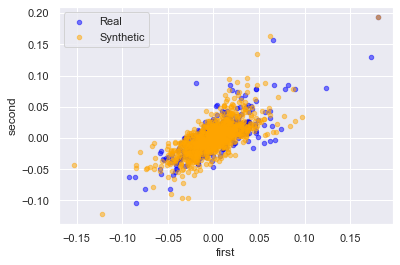

In [81]:
from copulas.visualization import scatter_2d, compare_2d

# GAUSSIAN BIVARIATE
compare_2d(bi_ret, sampled);

In [83]:
copula2 = bivariate.Frank()
copula2.fit(bi_ret.to_numpy())

ValueError: Marginal value out of bounds.

Here are a few key results:

1. Upper tail dependence means the two random variables are likely to have extremely large values together. For instance, when working with returns series, upper tail dependence implies that the two stocks are likely to have large gains together.
2. Lower tail dependence means the two random variables are likely to have small values together. This is much stronger in general compared to upper tail dependence, because stocks are more likely to go down together than going up.
3. Frank and Gaussian copulas do not have tail dependencies at all. And Gaussian copula infamously contributed to the 2008 financial crisis by pricing CDOs exactly for this reason.
4. Frank copula has a stronger dependence in the center compared to Gaussian.
5. For Value-at-Risk calculations, Gaussian copula is overly optimistic and Gumbel is too pessimistic [Kole et al., 2007].
6. Copulas with upper tail dependence: Gumbel, Joe, N13, N14, Student-t.
7. Copulas with lower tail dependence: Clayton, N14 (weaker than upper tail), Student-t.
8. Copulas with no tail dependence: Gaussian, Frank.

Now we can look back at the mystery at the very beginning of the article on what went wrong: 
- The bivariate Gaussian distribution assumes 
    - 1. All marginal random variables are Gaussian; 
    - 2. The copula that relates the two Gaussian marginals is also Gaussian. A Gaussian copula does not have any tail dependence. What’s worse, it requires symmetry on both upward co-moves and downward moves. 
    
Those assumptions are very rigid, and they just can’t compete with dedicated copula models for flexibility.